In [5]:
!pip install ggplot
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

import os
from os.path import join, exists
import sys
import numpy as np
import time

import urllib2
import json
from zipfile import ZipFile

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

import tensorflow as tf

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, Dense, Input, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, Layer, LSTM, Bidirectional, Convolution1D, GRU, add, concatenate
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, BaseLogger, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

from keras.utils import to_categorical, plot_model
from keras.utils import np_utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import Constant


from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.callbacks import Callback
import tensorflow_hub as hub
import tensorflow as tf
import re

import keras.layers as layers
from keras.layers import Input, Dropout, Dense, concatenate, Embedding, Flatten, Activation, SpatialDropout1D
from keras.layers import Bidirectional, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils
from keras.engine import Layer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, CuDNNGRU, CuDNNLSTM, Add, Reshape, SimpleRNN
from keras.layers import MaxPooling1D, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'

import re
import math
# set seed
np.random.seed(123)
le = LabelEncoder()

    100% |████████████████████████████████| 2.2MB 7.1MB/s 


/usr/local/lib/python2.7/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python2.7/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.
W0321 23:47:48.930572 140635839350656 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
training_sample_size = 1000 # Change this to -1 if you want all
max_seq_length = 30 # max 400

model_name = 'small'

lr = 0.001
lr_decay = 1e-4
epochs = 10
batch_size = 32


## Download GloVe

In [18]:
glove_url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
embedding_dim = 300
glove_filename = 'glove.840B.' + str(embedding_dim) + 'd.zip'
glove_loc = join(glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)



Download glove.840B.300d.zip
2176778240/2176768927 [==============================] - 848s 0us/step


In [19]:
glove_filename = os.path.join("datasets", 'glove.840B.300d.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract datasets/glove.840B.300d.txt
Embeddings size: 2196016


## **Loading Dataset**

In [0]:
def readFile(fileName):
  data = pd.read_csv(fileName, delimiter='\t', header = None, skiprows=1)
  data.columns = ["pair_ID", "sentence_A", "sentence_B", "relatedness_score", "entailment_judgment"]
  return data

In [0]:
train = readFile('SICK_train.txt')
test = readFile('SICK_test_annotated.txt')
valid = readFile('SICK_trial.txt')

In [0]:
train_df_features = train[['sentence_A','sentence_B']]
textsValid = valid[['sentence_A','sentence_B']]


In [0]:
labels = np_utils.to_categorical(le.fit_transform(train["entailment_judgment"].values)).astype("int64")

labelsValid = np_utils.to_categorical(le.fit_transform(valid["entailment_judgment"].values)).astype("int64")

textsTest = test[['sentence_A','sentence_B']]
labelsTest = np_utils.to_categorical(le.fit_transform(test["entailment_judgment"].values)).astype("int64")


In [0]:
train_sentence1 = train['sentence_A'].values.tolist()
train_sentence2 = train['sentence_B'].values.tolist()

valid_sentence1 = valid['sentence_A'].values.tolist()
valid_sentence2 = valid['sentence_B'].values.tolist()

## Prepare Word Embeddings

In [25]:
NUM_WORDS = len(embeddings) #200000

print('Found %s samples.' % len(train_sentence1))

train_sentences = train_sentence1 + train_sentence2
valid_sentences = valid_sentence1 + valid_sentence2


tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(train_sentences)

sentence1_word_sequences = tokenizer.texts_to_sequences(train_sentence1)
sentence2_word_sequences = tokenizer.texts_to_sequences(train_sentence2)

valid_sentence1_word_sequences = tokenizer.texts_to_sequences(valid_sentence1)
valid_sentence2_word_sequences = tokenizer.texts_to_sequences(valid_sentence2)


word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 4500 samples.
Found 2184 unique tokens.


In [0]:
from collections import defaultdict

words_len = min(NUM_WORDS, len(word_index))
# word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
max_word_count_text = 0
text_count = defaultdict(int)
for sentence in sentence1_word_sequences:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

max_word_count_hypo = 0
hypo_count = defaultdict(int)
for sentence in sentence2_word_sequences:
    max_word_count_hypo = max(max_word_count_hypo, len(sentence))
    hypo_count[len(sentence)] += 1
        

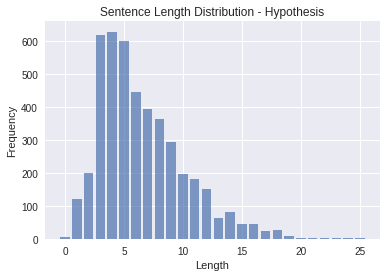

In [27]:

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(hypo_count)), hypo_count.values(), alpha=0.7)

plt.title("Sentence Length Distribution - Hypothesis")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [28]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))
print('Max word text: %d' % max_word_count_text)
print('Max word hypothesis: %d' % max_word_count_hypo)

Null word embeddings: -1
Found 2163
Total: 2185
Max word text: 28
Max word hypothesis: 32


In [29]:
s1_data = pad_sequences(sentence1_word_sequences, maxlen = max_seq_length)
s2_data = pad_sequences(sentence2_word_sequences, maxlen = max_seq_length)
s1_dataValid = pad_sequences(valid_sentence1_word_sequences, maxlen = max_seq_length)
s2_dataValid = pad_sequences(valid_sentence2_word_sequences, maxlen = max_seq_length)


labels = np_utils.to_categorical(le.fit_transform(train["entailment_judgment"].values)).astype("int64")
labelsValid = np_utils.to_categorical(le.fit_transform(valid["entailment_judgment"].values)).astype("int64")



print('Shape of sentence1 tensor:', s1_data.shape)
print('Shape of sentence2 tensor:', s2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of sentence1 tensor: (4500, 30)
Shape of sentence2 tensor: (4500, 30)
Shape of label tensor: (4500, 3)


In [30]:
print('One sample')

print('Text: ')
print( train_sentence1[0] )

print('Word sequence: ')
print( sentence1_word_sequences[0] )

print('Pad: ')
print( s1_data[0] )

One sample
Text: 
A group of kids is playing in a yard and an old man is standing in the background
Word sequence: 
[1, 63, 10, 114, 2, 12, 5, 1, 212, 6, 19, 271, 4, 2, 21, 5, 3, 213]
Pad: 
[  0   0   0   0   0   0   0   0   0   0   0   0   1  63  10 114   2  12
   5   1 212   6  19 271   4   2  21   5   3 213]


## Oversampling 

In [0]:
x1Dataframe = pd.DataFrame.from_records(s1_data)
x2Dataframe = pd.DataFrame.from_records(s2_data)
labels = pd.DataFrame.from_records(labels)


xxx = pd.concat([x1Dataframe, x2Dataframe], axis=1)
X = np.array(xxx.ix[:, :])
print('Shape of X: {}'.format(X.shape))

Y = np.array(labels.ix[:, :])
print('Shape of X: {}'.format(Y.shape))



Shape of X: (7608, 60)
Shape of X: (7608, 3)


In [0]:
from imblearn.over_sampling import SMOTE

smote = SMOTE('minority')

x_sm, labels = smote.fit_sample(X, Y)

x_sm, labels = smote.fit_sample(x_sm, labels)


In [0]:
dataframe = pd.DataFrame.from_records(x_sm)
dataframe.head()
print(x_sm.shape)

print(x_sm[:,0:max_seq_length].shape)

s1_data= x_sm[:,0:max_seq_length]
print(s1_data.shape)
s2_data= x_sm[:,max_seq_length:max_seq_length*2]
print(s2_data.shape)


(7608, 60)
(7608, 30)
(7608, 30)
(7608, 30)



## Helper methods.

In [0]:
eps = 1e-6

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def cosine_distance(y1, y2):
    mult =  tf.multiply(y1, y2)
    cosine_numerator = tf.reduce_sum( mult, axis = -1)
    y1_norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(y1), axis=-1 ), eps) ) 
    y2_norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(y2), axis=-1 ), eps) ) 
    return cosine_numerator / y1_norm / y2_norm

def cal_relevancy_matrix(text_vector, hypo_vector):
    text_vector_tmp = tf.expand_dims(text_vector, 1) # [batch_size, 1, question_len, dim]
    hypo_vector_tmp = tf.expand_dims(hypo_vector, 2) # [batch_size, passage_len, 1, dim]
    relevancy_matrix = cosine_distance(text_vector_tmp, hypo_vector_tmp) # [batch_size, passage_len, question_len]
    return relevancy_matrix

def mask_relevancy_matrix(relevancy_matrix, text_mask, hypo_mask):
    relevancy_matrix = tf.multiply(relevancy_matrix, K.expand_dims(text_mask, 1))
    relevancy_matrix = tf.multiply(relevancy_matrix, K.expand_dims(hypo_mask, 2))
    return relevancy_matrix

def max_mean_pooling(repres, cosine_matrix):
    
    repres.append(tf.reduce_max(cosine_matrix, axis = 2, keep_dims = True))
    repres.append(tf.reduce_mean(cosine_matrix, axis = 2, keep_dims = True))

    return repres

def matching_layer(inputs):
    forward_relevancy_matrix = cal_relevancy_matrix(inputs[0], inputs[2])
    backward_relevancy_matrix = cal_relevancy_matrix(inputs[1], inputs[3])

    representation = []

    max_mean_pooling(representation, forward_relevancy_matrix)
    max_mean_pooling(representation, backward_relevancy_matrix)
    
    return representation

## Matching layer

In [0]:
class MatchLayer(Layer):

    def __init__(self, dim, seq_length, **kwargs):
        super(MatchLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.dim = dim
        self.seq_length = seq_length
        
    def build(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('`MatchLayer` layer should be called '
                             'on a list of inputs')
        
        if all([shape is None for shape in input_shape]):
            return
        
        super(MatchLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs):
        if not isinstance(inputs, list):
            raise ValueError('A `MatchLayer` layer should be called ')
        
        return matching_layer(inputs)
    
    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('A `MatchLayer` layer should be called '
                             'on a list of inputs.')
        
        input_shapes = input_shape
        output_shape = list(input_shapes[0])
                             
        return [ (None, output_shape[1] , 1) ] * 4 
    
    def get_config(self):
        config = {

        }
        base_config = super(MatchLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class MaxPoolingLayer(Layer):

    def __init__(self, **kwargs):
        super(MaxPoolingLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaxPoolingLayer, self).build(input_shape)
    
    def call(self, inputs):
        return max_mean_pooling([], inputs)
    
    def compute_output_shape(self, input_shape):            
        output_shape = list(input_shape)
        return [ (None, output_shape[1] , 1) ] * 2
    
    def compute_mask(self, inputs, mask):
        return [mask, mask]


In [76]:
models = {};

def word_context(input, name):
    embedding = Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_seq_length,
                     trainable = False,
                     name = name + '_embedding')(input)
    
    word = Dropout(0.1)(embedding)

    context = Bidirectional(LSTM(100, return_sequences = True),
                            merge_mode = None,
                            name = name + '_context')(word)
    
    return (word, context)

def create_model():
    
    sentence1_input = Input(shape=(max_seq_length,), dtype='int32', name = 'text')
    sentence2_input = Input(shape=(max_seq_length,), dtype='int32', name = 'hypothesis')
    
    (text_embedding, text_context) = word_context(sentence1_input, 'text')
    (hypo_embedding, hypo_context) = word_context(sentence2_input, 'hypothesis')

    left_context = []
    left_context.extend(hypo_context)
    left_context.extend(text_context)
    
    left_match = MatchLayer(embedding_dim, max_seq_length)( left_context )
    
    right_context = []
    right_context.extend(text_context)
    right_context.extend(hypo_context)
    
    right_match = MatchLayer(embedding_dim, max_seq_length)( right_context )
    
    cosine_left = Lambda(lambda x_input: cal_relevancy_matrix(x_input[0], x_input[1]))( [text_embedding, hypo_embedding] )
    cosine_right = Lambda(lambda cosine: tf.transpose(cosine, perm=[0,2,1]))( cosine_left )
    
    left_representation = MaxPoolingLayer()( cosine_left )
    right_representation = MaxPoolingLayer()( cosine_right )
    
    left_representation.extend( left_match )
    right_representation.extend( right_match ) 
    
    left = concatenate(left_representation, axis = 2)
    left = Dropout(0.1)(left)
    
    right = concatenate(right_representation, axis = 2)
    right = Dropout(0.1)(right)
    

    aggregation_left = Bidirectional(LSTM(100),
                            name = 'aggregation_text_context')(left)
    
    aggregation_right = Bidirectional(LSTM(100),
                            name = 'aggregation_hypo_context')(right)
    
    aggregation = concatenate([aggregation_left, aggregation_right], axis = -1)
                               
    pred = Dense(200, activation = 'tanh', name = 'tanh_prediction')(aggregation)
    pred = Dense(3, activation = 'softmax', name = 'softmax_prediction')(pred)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model = Model(inputs=[sentence1_input, sentence2_input], outputs = pred)
    model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizer,
              metrics = ['accuracy'])
    
    print('Model created')
    
    return model


models['adam'] = create_model()



Model created


In [77]:
models['adam'].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 30)           0                                            
__________________________________________________________________________________________________
hypothesis (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
text_embedding (Embedding)      (None, 30, 300)      655500      text[0][0]                       
__________________________________________________________________________________________________
hypothesis_embedding (Embedding (None, 30, 300)      655500      hypothesis[0][0]                 
__________________________________________________________________________________________________
dropout_13

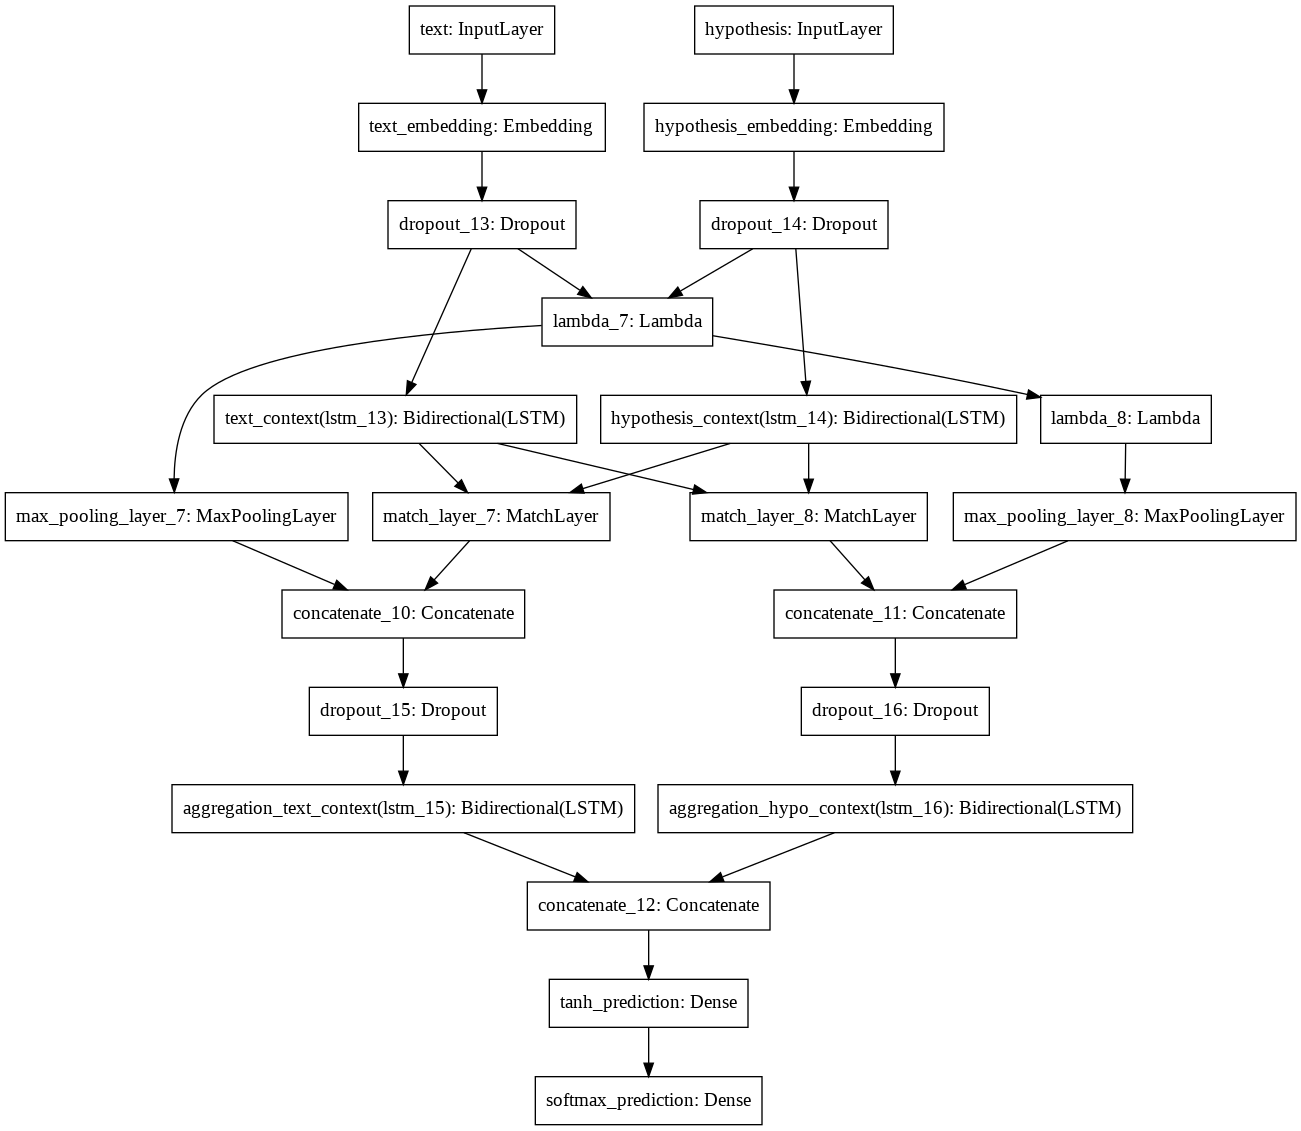

In [78]:
plot_model(models['adam'], to_file = model_name + '-model.png', show_shapes=False)
Image(filename = model_name + '-model.png')

## Train Model

In [79]:
s1_data.shape

(4500, 30)

In [80]:

results = []
for name, model in models.items():
    callbacks = [
        BaseLogger(),
        ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=5, min_lr=0.001),
        TensorBoard(log_dir='./' + model_name + '-' + name + '-logs', histogram_freq=0, write_graph=True, write_images=True),
        ModelCheckpoint(model_name + '-' + name + '-checkpoint-weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', save_best_only=True)
    ]
    
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit([s1_data, s2_data],
                        labels,
                        epochs = 30,
                        batch_size = batch_size,
                        validation_data=([s1_dataValid, s2_dataValid], labelsValid),
                        shuffle = False, #True,
                        verbose = 2,
                        callbacks = callbacks)

 #   model.save(model_name + '-' + name + '-model.h5')
 #   model.save_weights(model_name + '-' + name + '-weights.h5')

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    
    print('Time: %d' % (end_time - start_time))


Start learning adam at 1553229886
Epochs: 10
Batch size: 32
Train on 4500 samples, validate on 500 samples
Epoch 1/30
 - 73s - loss: 0.8924 - acc: 0.5924 - val_loss: 0.8020 - val_acc: 0.6040
Epoch 2/30
 - 64s - loss: 0.6937 - acc: 0.6907 - val_loss: 0.6705 - val_acc: 0.6520
Epoch 3/30
 - 64s - loss: 0.6238 - acc: 0.7122 - val_loss: 0.6217 - val_acc: 0.7280
Epoch 4/30
 - 65s - loss: 0.5783 - acc: 0.7311 - val_loss: 0.5950 - val_acc: 0.7220
Epoch 5/30
 - 64s - loss: 0.5436 - acc: 0.7513 - val_loss: 0.6117 - val_acc: 0.7200
Epoch 6/30
 - 63s - loss: 0.4934 - acc: 0.7791 - val_loss: 0.6357 - val_acc: 0.7220
Epoch 7/30
 - 64s - loss: 0.4546 - acc: 0.8009 - val_loss: 0.6517 - val_acc: 0.7520
Epoch 8/30
 - 64s - loss: 0.4065 - acc: 0.8184 - val_loss: 0.7351 - val_acc: 0.7060
Epoch 9/30
 - 64s - loss: 0.3816 - acc: 0.8351 - val_loss: 0.8118 - val_acc: 0.6740
Epoch 10/30
 - 64s - loss: 0.3372 - acc: 0.8567 - val_loss: 0.8134 - val_acc: 0.7080
Epoch 11/30
 - 64s - loss: 0.2833 - acc: 0.8847 - v

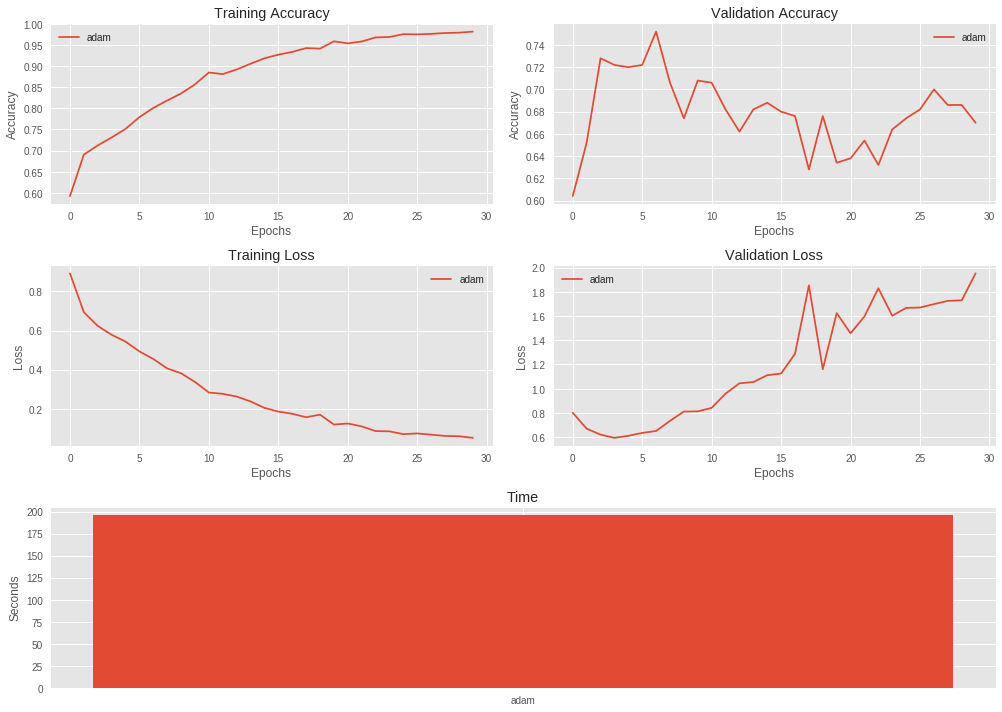

In [81]:
plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Training Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results], tick_label = models.keys(), align='center')

plt.tight_layout()
plt.savefig(model_name + '-acc-loss.png', dpi = 300)
#plt.show()

## Prediction and Model Evaluation


In [82]:
test_s1_word_sequences = tokenizer.texts_to_sequences(test['sentence_A'].values.tolist())
test_s2_word_sequences = tokenizer.texts_to_sequences(test['sentence_B'].values.tolist())

test_s1_data = pad_sequences(test_s1_word_sequences, maxlen = max_seq_length)
test_s2_data = pad_sequences(test_s2_word_sequences, maxlen = max_seq_length)
test_labels = np_utils.to_categorical(le.fit_transform(test["entailment_judgment"].values)).astype("int64")

print('Shape of test sentence1 tensor:', test_s1_data.shape)
print('Shape of test sentence2 tensor:', test_s2_data.shape)
print('Shape of test label tensor:', test_labels.shape)

Shape of test sentence1 tensor: (4927, 30)
Shape of test sentence2 tensor: (4927, 30)
Shape of test label tensor: (4927, 3)


In [83]:
for name, model in models.items():
    loss, accuracy = model.evaluate([test_s1_data, test_s2_data], test_labels)
    print('loss     = ', loss)
    print('accuracy = ', accuracy)

4927/4927 [==============================] - 23s 5ms/step
loss     =  1.7030310549865708
accuracy =  0.6969758473837233


In [0]:
for name, model in models.items():
    test_pred = model.predict([test_s1_data, test_s2_data], batch_size=32)
    

In [85]:
test_pred

array([[6.8183290e-08, 4.3926573e-08, 9.9999988e-01],
       [3.7047252e-07, 1.5178803e-04, 9.9984777e-01],
       [3.4712980e-06, 1.6585862e-05, 9.9997997e-01],
       ...,
       [6.0782462e-08, 5.3035283e-06, 9.9999464e-01],
       [6.8832628e-07, 2.9809278e-06, 9.9999630e-01],
       [1.4718914e-07, 3.3651231e-04, 9.9966335e-01]], dtype=float32)

In [0]:
output= list()
for x in test_pred:
  output.append(["CONTRADICTION", "ENTAILMENT", "NEUTRAL"][np.argmax(x)])

test["Actual Output"] = output

test.to_excel("output.xlsx")

In [87]:
from sklearn.metrics import classification_report

predicted = np.argmax(test_pred, axis=1)
report = classification_report(test["entailment_judgment"], test["Actual Output"])
print(report)


               precision    recall  f1-score   support

CONTRADICTION       0.67      0.72      0.69       720
   ENTAILMENT       0.66      0.48      0.56      1414
      NEUTRAL       0.72      0.80      0.76      2793

    micro avg       0.70      0.70      0.70      4927
    macro avg       0.68      0.67      0.67      4927
 weighted avg       0.69      0.70      0.69      4927

